## Sea Surface Temperature Prediction using Proper Orthogonal Decomposition (POD)

----

### 1 Dataset Preprocessing
Dataset used in this project: [NOAA daily optimum interpolation sea surface temperature dataset (DOISST)](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html)

In spatial terms, our dataset covers the northeast Atlantic, the southern Norwegian sea, and the entire area of the North Sea. The latitude and longitude range from 26.5° W to 12.5° E and from 51.5° N to 67.5° N respectively. Every two data points are spaced one degree apart. As for the temporal dimension, our dataset includes monthly sea surface temperature data for nearly 40 years, from December 1981 to January 2020.

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.basemap import Basemap

In [2]:
# data preprocessing
data_part1 = nc.Dataset('dataset/p1.nc')
data_part2 = nc.Dataset('dataset/p2.nc')

sst1 = data_part1.variables['sst'][:]
sst2 = data_part2.variables['sst'][:]

new_sst = []
flatten = []

for i in range(len(sst1)):
    scatter = np.hstack((sst1[i],sst2[i]))
    scatter = np.flip(scatter, 0)
    flat = scatter.flatten()
    
    new_sst.append(scatter.tolist())
    flatten.append(flat.tolist())

sst_array = np.array(new_sst)
flatten_array = np.array(flatten)
print(sst_array.shape)

(458, 17, 40)


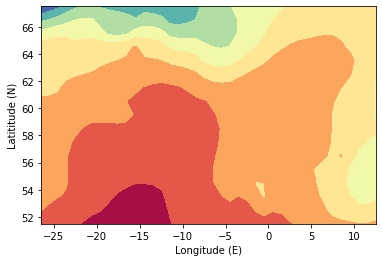

In [3]:
# visualization of the last month data in the dataset
lat = 17
lon = 40

norm = colors.Normalize(vmin=0.26708400509262376, vmax=11.474137583723175)

X, Y = np.meshgrid(np.arange(-26.5, 13.5, 1), np.arange(51.5, 68.5, 1))

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
c = ax.contourf(X, Y, sst_array[457], cmap='Spectral_r', norm=norm)
plt.xlabel("Longitude (E)")
plt.ylabel("Latititude (N)")
plt.show()

### 2 Applying POD to the dataset
The collection of the data points corresponding to a certain timestamp is known as a "snapshot". Each snapshot can be expressed as a term related to both location $\mathbf{x}$ and time $t$:
$$
\mathbf{S}_i = [d_1, d_2, d_3, ..., d_n] = SST(\mathbf{x}, t),
$$
where $\mathbf{S}_i$ is a snapshot at time $i$ that contains $n$ data points $d_1, d2, ..., d_n$. In our case, $n = 17\times 40=680$.

The goal of POD is to decompose every snapshot into the following forms:
$$
\mathbf{S}_i = SST(\mathbf{x}, t) = \sum_{k=1}^{m}a_k(t)\Phi_k(\mathbf{x}),
$$
where each $\Phi_k(\mathbf{x})$ is a POD mode that represent a certain kind of sea surface temperature distribution. This term is only related to the location vector $\mathbf{x}$. The function $a_k(t)$ is the corresponding time coefficient which only related to time $t$.

#### Step 1
We start by subtracting the average SST from every snapshot to obtain a new snapshot matrix.

In [4]:
flatten_mean = np.mean(flatten_array, axis=0)
for i in range(flatten_array.shape[0]):
    flatten_array[i, :] -= flatten_mean
print(flatten_array.shape)

(458, 680)


#### Step 2
We then calculate the data covariance matrix $C = \frac{1}{m-1}D^{\prime T}D^{\prime} ( C \in \mathbb{R}^{n\times n} )$, and compute all its eigenvalues and corresponding eigenvectors. We order all $n$ eigenvalues in a descent order and obtain an $n\times n$ matrix $\Phi$ which contains $n$ eigenvectors as column vectors.

In [5]:
m = flatten_array.shape[0]
n = flatten_array.shape[1]

cov = (1 / (m - 1)) * (flatten_array.T @ flatten_array)
print(cov.shape)

(680, 680)


In [6]:
eigvalue, eigvector = np.linalg.eig(cov)

eigvalue = np.real(eigvalue)
eigvector = np.real(eigvector)

for i in range(eigvalue.shape[0]):
# Manually clean those vectors which correspond to 
# eigenvalues that should equal to zero
    if eigvalue[i] < 1e-7:
        eigvalue[i] = 0
        eigvector[:, i] = np.zeros(eigvector.shape[0])
        
cnt = 0
for i in range(len(eigvalue)):
    cnt += eigvalue[i]

for i in range(3):
    print("Top {} eigenvalue: {}".format(i + 1, eigvalue[i]))
    print("Proportion of the sum of all eigenvalues: " + str(eigvalue[i] / cnt))
    print()
print("Proportion of the sum of all eigenvalues for the first three eigenvalues:")
print((eigvalue[0] + eigvalue[1] + eigvalue[2]) / cnt)

Top 1 eigenvalue: 4645.04108010293
Proportion of the sum of all eigenvalues: 0.9396307222862479

Top 2 eigenvalue: 115.15810605236672
Proportion of the sum of all eigenvalues: 0.023294970378325248

Top 3 eigenvalue: 52.75628893424903
Proportion of the sum of all eigenvalues: 0.010671903438867314

Proportion of the sum of all eigenvalues for the first three eigenvalues:
0.9735975961034404


The $n$ eigenvectors (the $n$ columns of $\Phi$), which ordered from left to right according to the value of their corresponding eigenvalues, are the **POD modes** of the dataset. A large eigenvalue indicates that its corresponding POD mode (eigenvector) has a large kinetic energy.

We can find that the first 3 eigenvalues account for 97% of the sum of all eigenvalue. Therefore, in the following mode decomposition process, we can **discard other modes with smaller eigenvalues and only retain the first three most important modes**.

#### Step 3
By projecting the original matrix $D^{\prime}$ onto $\Phi$, we obtain a projection matrix $A = D^{\prime}\Phi$. To decode the original matrix from $A$, we can compute $D^{\prime} = A \Phi^T$.

In [7]:
for i in range(eigvector.shape[1]):
    vec = eigvector[:, i]
    norm = np.linalg.norm(vec)
    if norm == 0:
        norm = 1
    eigvector[:, i] = vec / norm
    
A = flatten_array @ eigvector
print(A.shape)

(458, 680)


As we only retain the first three most import modes, we can use an approximate representation to represent the original matrix $D^{\prime}$:
$$
\hat{D}=\sum_{k=1}^3 \mathbf{a}_k \mathbf{v}^T_k \approx D^{\prime}.
$$

In [8]:
pod1 = eigvector[:, 0].reshape((1, n))
pod2 = eigvector[:, 1].reshape((1, n))
pod3 = eigvector[:, 2].reshape((1, n))

t1 = A[:, 0]
t2 = A[:, 1]
t3 = A[:, 2]

tn1 = A[:, 0].reshape((m, 1))
tn2 = A[:, 1].reshape((m, 1))
tn3 = A[:, 2].reshape((m, 1))

# reconstruct D' using only the first three POD modes
recov = (tn1 @ pod1 + tn2 @ pod2 + tn3 @ pod3)

for i in range(recov.shape[0]):
    recov[i, :] += flatten_mean
    
for i in range(flatten_array.shape[0]):
    flatten_array[i, :] += flatten_mean

print(recov.shape)

(458, 680)


We can obtain that every eigenvector $\mathbf{v}_k$ is the spatial POD mode and every time vector $\mathbf{a}_k$ is its corresponding time coefficient. This indicates that we have finished the decomposition of our original dataset $D^\prime$. The three modes and their corresponding time coefficients are visualized below.

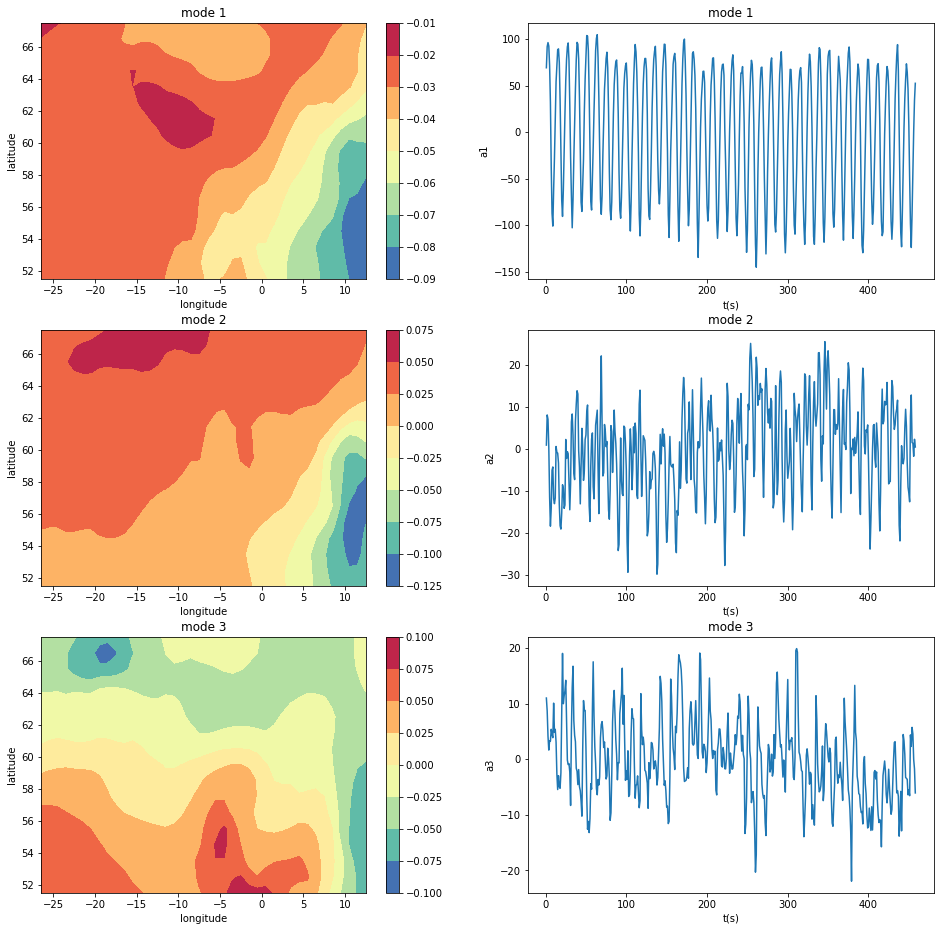

In [9]:
timepast = np.arange(1, 459, 1).reshape(-1, 1)
lat = 17
lon = 40

pod_list = [pod1, pod2, pod3]
time_list = [t1, t2, t3]

X, Y = np.meshgrid(np.arange(-26.5, 13.5, 1), np.arange(51.5, 68.5, 1))

fig = plt.figure(figsize=(16, 16))

for i in range(3):
    ax = fig.add_subplot(3, 2, i*2 + 1)
    ax.set_title("mode {}".format(i + 1))
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    c = ax.contourf(X, Y, pod_list[i].reshape((lat, lon)), cmap='Spectral_r')
    cb = fig.colorbar(c)

    ax = fig.add_subplot(3, 2, i*2 + 2)
    ax.set_title("mode {}".format(i + 1))
    c = ax.plot(timepast, time_list[i])
    ax.set_xlabel('t(s)')
    ax.set_ylabel('a{}'.format(i + 1))

plt.show()

### 3 Predicting Sea Surface Temperature using Linear Regression and Fourier Transformation

Since POD modes are only related to geographical features, we can assume that these features do not change significantly over the next fifty years, that is, the eigenvector $\mathbf{v}_k$ does not change. Therefore, the overall prediction of sea surface temperature can be achieved by predicting the subsequent changes of each time vector $\mathbf{a}_k$. We proceed our prediction by using linear regression to obtain the overall trend and Fourier transformation to approximate the periodicity characteristic of the time coefficients.

In [10]:
from sklearn.linear_model import LinearRegression
from scipy.fftpack import fft,ifft

timepast = np.arange(1, 459, 1).reshape(-1, 1)

ls1 = LinearRegression()
ls1.fit(timepast, t1)
y1 = ls1.predict(timepast)

ls2 = LinearRegression()
ls2.fit(timepast, t2)
y2 = ls2.predict(timepast)

ls3 = LinearRegression()
ls3.fit(timepast, t3)
y3 = ls3.predict(timepast)

# compute the slope and interception for the time coefficients
print("Slope and interception for the first three time coefficients:")
print(ls1.coef_, ls1.intercept_)
print(ls2.coef_, ls2.intercept_)
print(ls3.coef_, ls3.intercept_)

Slope and interception for the first three time coefficients:
[-0.06652336] 15.267111345627217
[0.02097273] -4.813241301462371
[-0.01655826] 3.800119949515265


In [11]:
# perform Fourier transformation after removing the overall trend of the time coefficient
fft_y1 = (t1 - y1)[1:457]
fft_y2 = (t2 - y2)[1:457]
fft_y3 = (t3 - y3)[1:457]

x = timepast[1:457]

yf1 = fft(fft_y1)
yf2 = fft(fft_y2)
yf3 = fft(fft_y3)

# obtain amplitude
abs_yf1 = np.abs(yf1)
abs_yf1 = abs_yf1[0: int(len(x)/2) + 1]

abs_yf2 = np.abs(yf2)
abs_yf2 = abs_yf2[0: int(len(x)/2) + 1]

abs_yf3 = np.abs(yf3)
abs_yf3 = abs_yf3[0: int(len(x)/2) + 1]

# obtain phase
angle_y1 = np.angle(yf1)
angle_y1 = angle_y1[0: int(len(x)/2) + 1]

angle_y2 = np.angle(yf2)
angle_y2 = angle_y2[0: int(len(x)/2) + 1]

angle_y3 = np.angle(yf3)
angle_y3 = angle_y3[0: int(len(x)/2) + 1]

a1 = abs_yf1[0] / 456
a2 = abs_yf2[0] / 456
a3 = abs_yf2[0] / 456

sort_yf1 = sorted(enumerate(abs_yf1.tolist()), key=lambda x: x[1], reverse=True)
sort_yf2 = sorted(enumerate(abs_yf2.tolist()), key=lambda x: x[1], reverse=True)
sort_yf3 = sorted(enumerate(abs_yf3.tolist()), key=lambda x: x[1], reverse=True)
yf1_para = []
yf2_para = []
yf3_para = []
for i in range(10):
    ii = sort_yf1[i][0]
    yf1_para.append([abs_yf1[ii] * 2.0 / 456, angle_y1[ii], ii])

for i in range(10):
    ii = sort_yf2[i][0]
    yf2_para.append([abs_yf2[ii] * 2.0 / 456, angle_y2[ii], ii])
    
for i in range(10):
    ii = sort_yf3[i][0]
    yf3_para.append([abs_yf3[ii] * 2.0 / 456, angle_y3[ii], ii])

The prediction results are illustrated in the figure below. The blue lines indicate our training data and the orange lines are the predictions of our model.

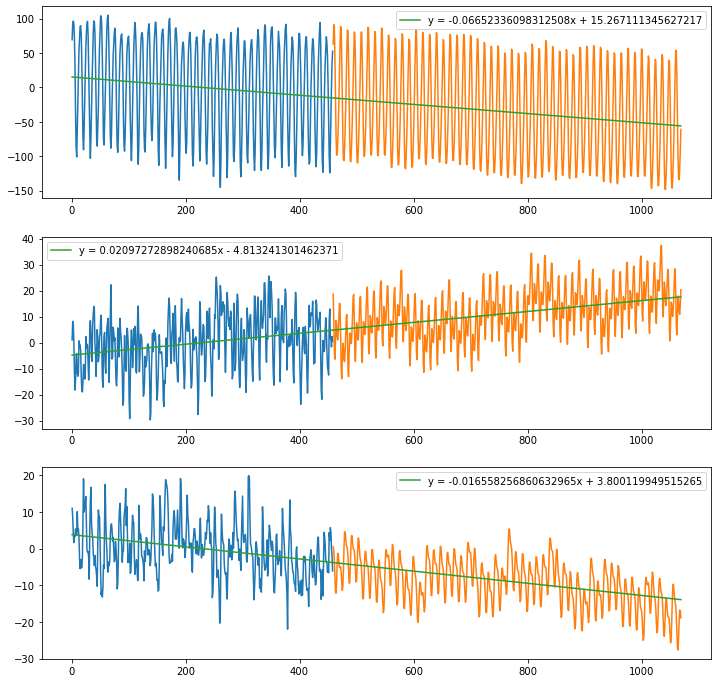

In [12]:
timefuture = np.arange(459, 1070, 1)
t1_reg = a1
for i in range(10):
    t1_reg += yf1_para[i][0] * np.sin(2 * np.pi * (yf1_para[i][2] / 456) * timefuture + yf1_para[i][1])
    
t2_reg = a2
for i in range(10):
    t2_reg += yf2_para[i][0] * np.sin(2 * np.pi * (yf2_para[i][2] / 456) * timefuture + yf2_para[i][1])
    
t3_reg = a3
for i in range(10):
    t3_reg += yf3_para[i][0] * np.sin(2 * np.pi * (yf3_para[i][2] / 456) * timefuture + yf3_para[i][1])

t1_reg = t1_reg + ls1.predict(timefuture.reshape((-1, 1)))
t2_reg = t2_reg + ls2.predict(timefuture.reshape((-1, 1)))
t3_reg = t3_reg + ls3.predict(timefuture.reshape((-1, 1)))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(3, 1, 1)
ax.plot(timepast, t1)
ax.plot(timefuture, t1_reg)
ax.plot([1, 1069], ls1.predict([[1], [1069]]), label="y = {}x + {}".format(ls1.coef_[0], ls1.intercept_))
ax.legend()

ax = fig.add_subplot(3, 1, 2)
ax.plot(timepast, t2)
ax.plot(timefuture, t2_reg)
ax.plot([1, 1069], ls2.predict([[1], [1069]]), label="y = {}x - {}".format(ls2.coef_[0], abs(ls2.intercept_)))
ax.legend()

ax = fig.add_subplot(3, 1, 3)
ax.plot(timepast, t3)
ax.plot(timefuture,t3_reg)
ax.plot([1, 1069], ls3.predict([[1], [1069]]), label="y = {}x + {}".format(ls3.coef_[0], ls3.intercept_))
ax.legend()

plt.show()

By multiplying these time coefficients with their corresponding eigenvector (POD modes), we obtain the reconstructed prediction for sea surface temperature over the next 50 years.

In [13]:
map_list = flatten_array.tolist()

for i in timefuture:
    ii = i - 459
    predict = (t1_reg[ii] * pod1 + t2_reg[ii] * pod2 + t3_reg[ii] * pod3).reshape(n) + flatten_mean
    map_list.append(predict.tolist())
    
map_array = np.array(map_list)
map_array.shape

(1069, 680)

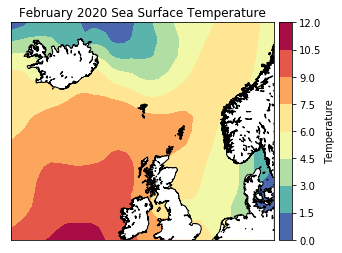

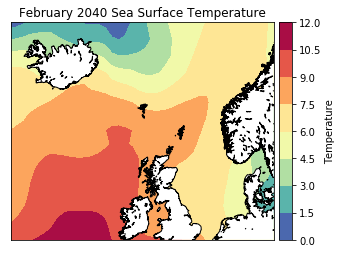

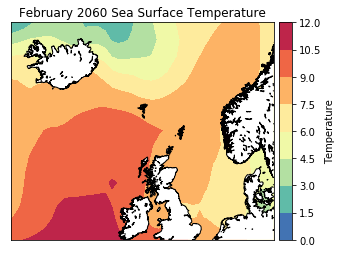

In [19]:
# n = 640
lat = 17
lon = 40

norm = colors.Normalize(vmin=0.26708400509262376, vmax=11.474137583723175)
# -------- 1982.1 ---------
original = map_array[1, :] # 
recovered = recov[1, :]

X, Y = np.meshgrid(np.arange(-26.5, 13.5, 1), np.arange(51.5, 68.5, 1))
original = original.reshape((lat, lon))
recovered = recovered.reshape((lat, lon))

map = Basemap(llcrnrlon = -26.5, llcrnrlat = 51.5, urcrnrlon = 12.5, urcrnrlat = 67.5, resolution='h', projection='merc')
map.fillcontinents(color = 'white')
map.drawcoastlines()
XX, YY = map(X, Y)
c = map.contourf(XX, YY, map_array[459, :].reshape((lat, lon)), cmap='Spectral_r', norm=norm)

cb = map.colorbar(c)
cb.set_label('Temperature')
plt.title("February 2020 Sea Surface Temperature")
plt.show()

map = Basemap(llcrnrlon = -26.5, llcrnrlat = 51.5, urcrnrlon = 12.5, urcrnrlat = 67.5, resolution='h', projection='merc')
map.fillcontinents(color = 'white')
map.drawcoastlines()
XX, YY = map(X, Y)

c = map.contourf(XX, YY, map_array[699, :].reshape((lat, lon)), cmap='Spectral_r', norm=norm)
cb = map.colorbar(c)
cb.set_label('Temperature')
plt.title("February 2040 Sea Surface Temperature")
plt.show()

map = Basemap(llcrnrlon = -26.5, llcrnrlat = 51.5, urcrnrlon = 12.5, urcrnrlat = 67.5, resolution='h', projection='merc')
map.fillcontinents(color = 'white')
map.drawcoastlines()
XX, YY = map(X, Y)
c = map.contourf(XX, YY, map_array[939, :].reshape((lat, lon)), cmap='Spectral_r')

cb = map.colorbar(c)
cb.set_label('Temperature')
plt.title("February 2060 Sea Surface Temperature")
plt.show()